In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from sklearn import preprocessing, cross_validation, svm, neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

c:\users\luiz_\dropbox\personal\python\programs\my_jupyter_lab\jlab_env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Plot font size settings
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
base_filepath = r'c:/Users/luiz_/Downloads/McK Datasets'
train_filepath = r'c:/Users/luiz_/Downloads/McK Datasets/train_ZoGVYWq.csv'
test_filepath = r'c:/Users/luiz_/Downloads/McK Datasets/test_66516Ee.csv'
sample_sub_filepath = r'c:/Users/luiz_/Downloads/McK Datasets/sample_submission_sLex1ul (1).csv'

In [4]:
df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)
sample_df = pd.read_csv(sample_sub_filepath)

## Training Dataset

In [5]:
df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


## Test Dataset

In [6]:
test_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


## Sample Submission Dataset

In [7]:
sample_df.head()

,id,renewal,incentives
0,649,0.5,1650
1,81136,0.5,1650
2,70762,0.5,1650
3,53935,0.5,1650
4,15476,0.5,1650


## Objective

Your client is an Insurance company and they need your help in building a model to predict the propensity to pay renewal premium and build an incentive plan for its agents to maximise the net revenue (i.e. renewals - incentives given to collect the renewals) collected from the policies post their issuance.

Given the information, the client wants you to predict the propensity of renewal collection and create an incentive plan for agents (at policy level) to maximise the net revenues from these policies.

### Additional Details

You have information about past transactions from the policy holders along with their demographics. The client has provided aggregated historical transactional data like number of premiums delayed by 3/ 6/ 12 months across all the products, number of premiums paid, customer sourcing channel and customer demographics like age, monthly income and area type.

In addition to the information above, the client has provided the following relationships:

1. Expected effort in hours put in by an agent for incentives provided; and
2. Expected increase in chances of renewal, given the effort from the agent.

## Evaluation Criteria

Your solutions will be evaluated on 2 criteria:

1. The base probability of receiving a premium on a policy without considering any incentive
2. The monthly incentives you will provide on each policy to maximize the net revenue

## Key Questions

1. What variables most directly affect renewall probability? i.e., what matters and what doesnt?
2. What type of model should I use to predict probabilities? (KNN?, logistic regression?)

In [8]:
# Net Revenue Function

def revenue(probability, premium, incentive):
    """
    Calculates the expected revenue for a given account using the
    probability of renewal (calculated by the insurance co), the
    probability increase due to agent effort and the incentive
    offered.
    
    Inputs:
        probability : probability of renewal as given by benchmark model
        prob_inc : increase in probability as determined by agent effort
        premium : premium being paid (revenue)
        incentive : incentive being paid out to agents (cost)
    """
    prob_inc = prob_increase_pct(effort(incentive))
    probability /= 100
    prob_inc /= 100
    improved_probability = (probability * (1 + prob_inc))
    # Need to ensure that the probability does not go above 1
    improved_probability = np.where(improved_probability > 1, 1, improved_probability)
    return  improved_probability * premium - incentive

# Effort Incentive Curve
# Y = 10*(1-exp(-X/400))

def effort(incentive):
    """
    Agent effort output is a function of monetary incentive
    
    Inputs:
        incentive : int or float, amount of money incentive for a given renewal
        
    Returns:
        effort : float, amount of effort that the agent will give to this renewal
    """
    return 10 * (1 - np.exp(-incentive / 400))

# Renewal Probability Improvement function
# Y = 20*(1-exp(-X/5))

def prob_increase_pct(effort):
    """
    With additional units of effort the probability of renewal is increased
    
    Inputs:
        effort : float, amount of effort that the agent will give to this renewal
    
    Returns:
        prob_increase_pct : float, the percent increase in the probability of renewal
    """
    return 20 * (1 - np.exp(-effort / 5))

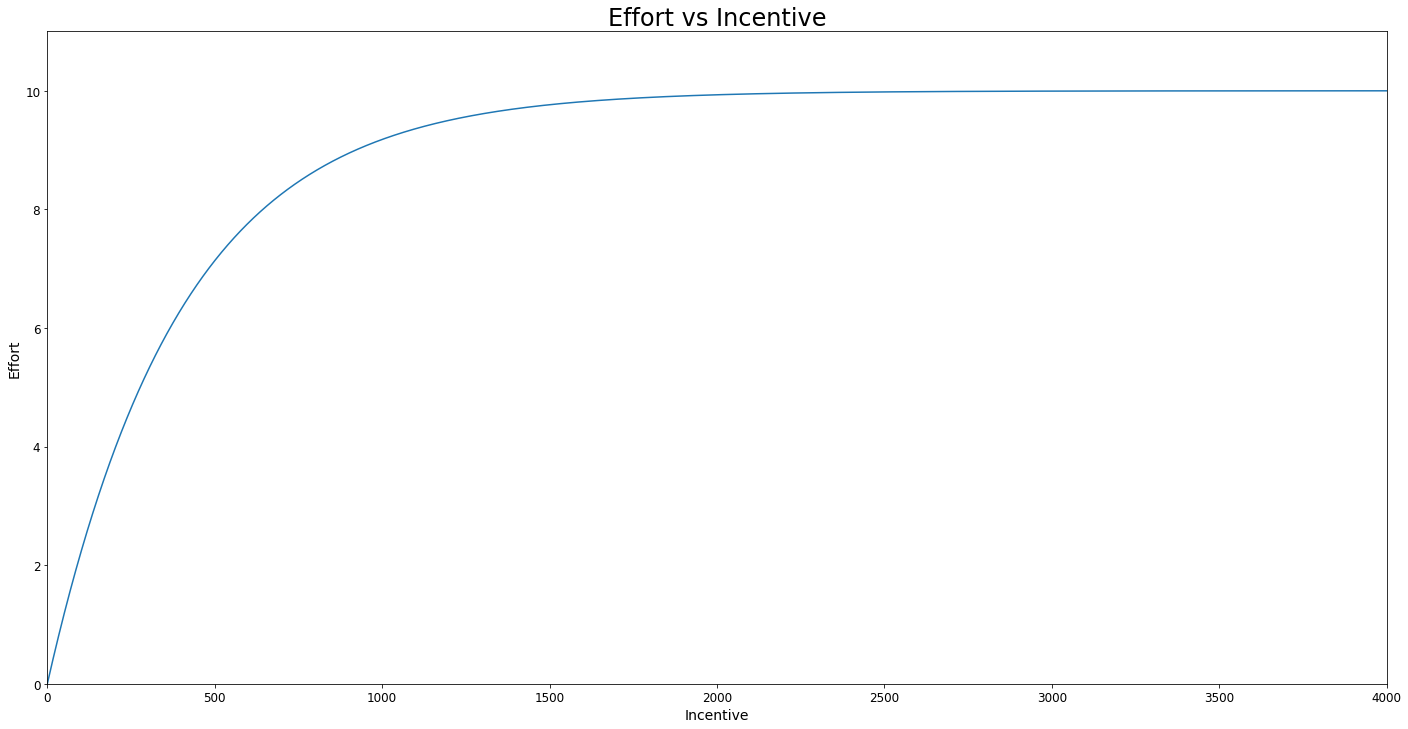

In [9]:
incentives = np.arange(0, 10 ** 4)
efforts = effort(incentives) 

fig, ax = plt.subplots()
ax.set_title('Effort vs Incentive')
ax.set_ylabel('Effort')
ax.set_xlabel('Incentive')
ax.set_xlim(0, 4000)
ax.set_ylim(0,11)
fig.set_size_inches(24, 12)
plt.plot(incentives, efforts)
plt.show()

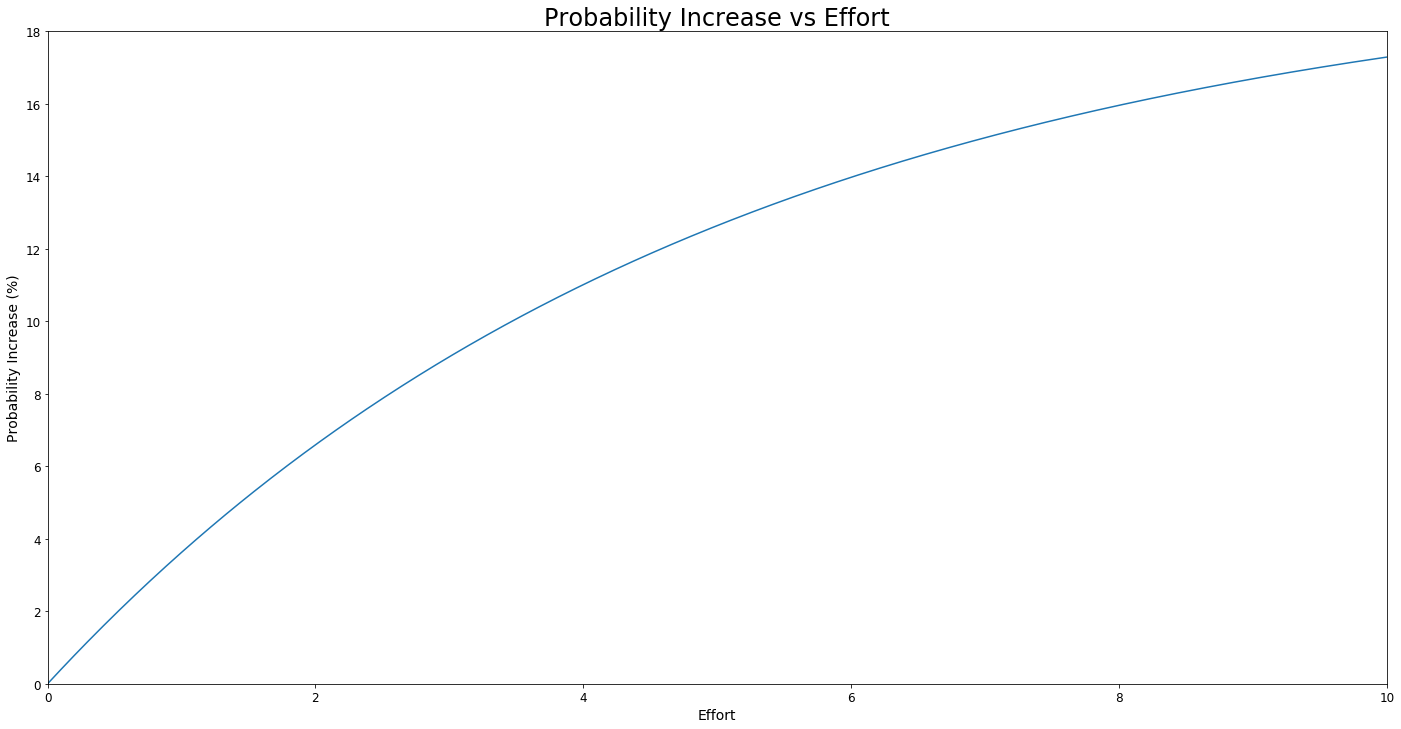

In [10]:
prob_incs = prob_increase_pct(efforts)

fig, ax = plt.subplots()
ax.set_title('Probability Increase vs Effort')
ax.set_ylabel('Probability Increase (%)')
ax.set_xlabel('Effort')
ax.set_xlim(0, 10)
ax.set_ylim(0,18)
fig.set_size_inches(24, 12)
plt.plot(efforts, prob_incs)
plt.show()

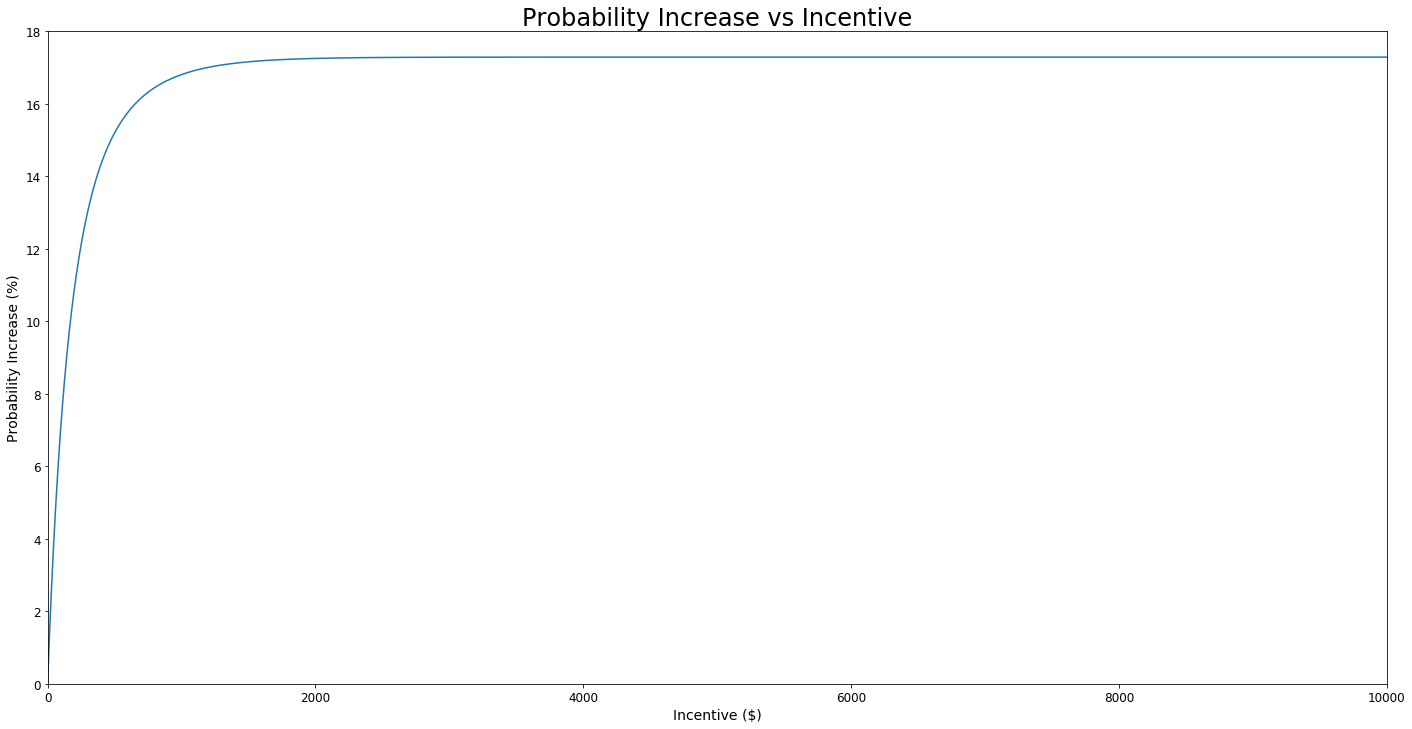

In [11]:
# Prob Inc vs Incentive

fig, ax = plt.subplots()
ax.set_title('Probability Increase vs Incentive')
ax.set_ylabel('Probability Increase (%)')
ax.set_xlabel('Incentive ($)')
ax.set_xlim(0, 10000)
ax.set_ylim(0,18)
fig.set_size_inches(24, 12)
plt.plot(incentives, prob_incs)
plt.show()

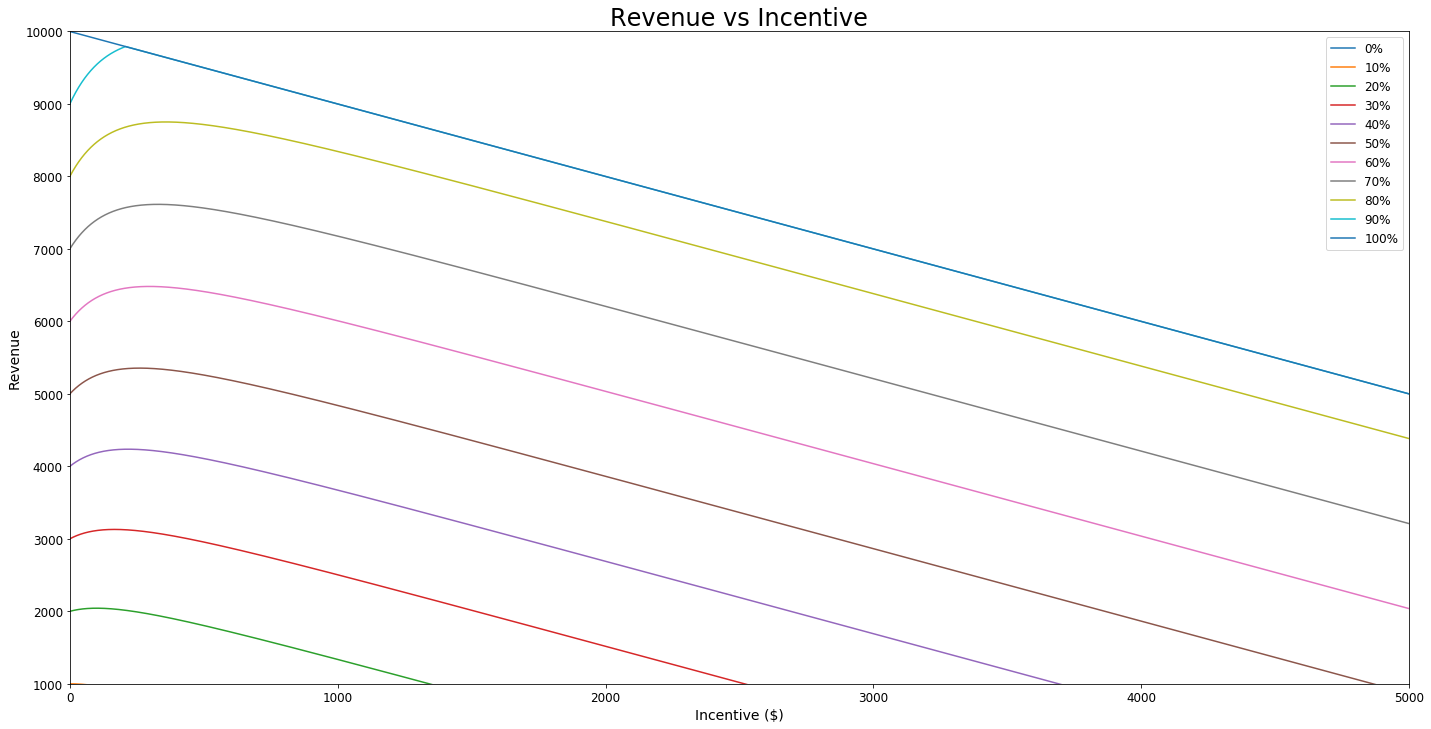

In [12]:
# Given a a range of renewal probabilities and a $10,000 premium these are the net revenues for a given customer
# over different incentive levels

fig, ax = plt.subplots()
fig.set_size_inches(24, 12)
ax.set_title('Revenue vs Incentive')
ax.set_ylabel('Revenue')
ax.set_xlabel('Incentive ($)')
ax.set_xlim(0, 5000)
ax.set_ylim(1000, 10000)

premium = 10 ** 4
probabilities = [_ for _ in range(0,101,10)]
for probability in probabilities:
    revenues = revenue(probability, premium, incentives)
    plt.plot(incentives, revenues, label=f'{probability}%')
ax.legend()

In [13]:
# test revenue function
revenues = revenue(95, premium, incentives)
print(revenues[0])
print(revenues[10])
print(revenues.max())

9500.0
9581.54351593071
9933.0


## Optimization of Revenue

By varying the incentive given to agents there is a global optimum to be achieved. In order to determine this relationship we first find the probability increase as a function of incentive.

$$effort = 10 \bullet \left( 1 - e^{- \frac{incentive}{400}} \right)$$

and

$$prob_{increase} = 20 \bullet \left( 1 - e^{- \frac{effort}{5}} \right)$$

leading to the relationship between probability increase and incentive to be:

$$prob_{increase} = 20 \bullet \left( 1 - e^{- \frac{10 \bullet \left( 1 - e^{- \frac{incentive}{400}} \right)}{5}} \right) $$

This can be slightly simplified to:

$$ prob_{increase} = 20 \bullet \left( 1 - e^{-2 \bullet \left( 1 - e^{- \frac{incentive}{400}} \right)} \right) $$

Revenue for a single customer can then be expressed as:

$$
  revenue_i =
\begin{cases}
\left(\frac{prem}{100}\right) \bullet p_i \bullet (100 + prob_{increase}) - incentive,  & \text{if $p_i \bullet (100 + prob_{increase}) \le 100$} \\
premium - incentive, & \text{if $p_i \bullet (100 + prob_{increase}) > 100$}
\end{cases}
$$

We can then substitute the function for probability increase into this function and use Python's numerical math libraries to compute the global maximum.

In [14]:
def revenue_closure(probability, premium):
    """
    Returns a function for revenue that is dependent on only one
    variable: the incentive amount.
    
    Inputs:
        probability : int or float, the probability of renewal (ranges from 0-100)
        premium : int, the premium amount of the policy
    
    Returns:
        rev: function, computes revenue based on incentive amount
    """
    def rev(incentive):
        return revenue(probability, premium, incentive)
    return rev


def optimal_incentive(probability, premium):
    """
    Uses scipy's 'fminbound' function to maximize the revenue function with respect to
    the incentive given to the agent. I have not attempted to solve the equation
    analytically since for a dataset of this size it is not costly to just use
    numerical methods to find the optimum.
    
    Inputs:
        probability : int or float, the probability of renewal (ranges from 0-100)
        premium : int, the premium amount of the policy
    
    Returns:
        optimal_incentive : the incentive amount that produces the highest revenue
                            for a given policy renewal probability and premium
    """
    rev = revenue_closure(probability, premium)
    optimal_incentive = float(fminbound(lambda incentive: -rev(incentive),0, premium, disp=False)) 
    return optimal_incentive

In [15]:
# test optimal_incentive
print(f'Optimum incentive is ${optimal_incentive(95, 10000):,.2f}')
print(f'Revenue with $65 incentive: ${revenue(95, 10000, 65):,.2f}')
print(f'Revenue with $66 incentive: ${revenue(95, 10000, 66):,.2f}')
print(f'Revenue with ${optimal_incentive(95, 10000):,.2f} incentive: ${revenue(95, 10000, optimal_incentive(95, 10000)):,.2f}')
print(f'Revenue with $67 incentive: ${revenue(95, 10000, 67):,.2f}')

Optimum incentive is $66.28
Revenue with $65 incentive: $9,927.40
Revenue with $66 incentive: $9,932.36
Revenue with $66.28 incentive: $9,933.72
Revenue with $67 incentive: $9,933.00


## Feature selection

What features matter in our dataset?

**Seems important**:

- Percent premium paid in cash or credit: this value seems to be very strongly correlated with renewal probability
- Total number of late payments: very strong indicator
- Number of premiums paid: anythin less than 3 premiums paid shows a low rate of renewal
- Age in days: Higher age correlates to higher chance of renewal

**Some correlation**:

- Absolute income
- Income to premium ratio
- Absolute premium amount: lower premiums seem to have lower renewal rates

**Does not seem matter at all**:
- Residence (urban vs rural)
- Application score (does not seem to make a big diff)
- Channel (may or may not matter, channel A seems to have higher renewal rates)

## Submission

In [19]:
# clean  the data
df_training = df
df_training.index = df_training['id']
df_training = df_training.drop(columns=['id'])

# There are close to 3000 rows that have missing data of some form
df_training = df_training.dropna()
df_training = df_training.drop(columns=['sourcing_channel', 'residence_area_type'])

In [20]:
df_training.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
id,,,,,,,,,,
110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,3300,1
41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,18000,1
31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,3300,0
19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,9600,1
99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,9600,1


In [21]:
# Calculated column - whether or not there are _any_ late payments
df_training['any_late'] = df_training['Count_3-6_months_late'] + df['Count_6-12_months_late'] + df['Count_more_than_12_months_late']
#df_training['less_than_2_prem_paid'] = (df_training['no_of_premiums_paid'] < 2).astype(int)

# Move 'any_late' column to the front so that the variable were interested in is the last column
cols = df_training.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_training = df_training[cols]

# Lets get ride of rid of the late columns to see what other variables come up
df_training = df_training.drop(columns=['Count_3-6_months_late', 'Count_6-12_months_late', 'Count_more_than_12_months_late'])

In [22]:
df_training.head()

,any_late,perc_premium_paid_by_cash_credit,age_in_days,Income,application_underwriting_score,no_of_premiums_paid,premium,renewal
id,,,,,,,,
110936,0.0,0.429,12058,355060,99.02,13,3300,1
41492,0.0,0.010,21546,315150,99.89,21,18000,1
31300,6.0,0.917,17531,84140,98.69,7,3300,0
19415,0.0,0.049,15341,250510,99.57,9,9600,1
99379,0.0,0.052,31400,198680,99.87,12,9600,1


In [23]:
array = df_training.values
X = array[:,0:7]
X = preprocessing.scale(X)
Y = array[:,7]

# Limit model to 5 features
model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {fit.support_}")
print(f"Feature Ranking: {fit.ranking_}")

Num Features: 5
Selected Features: [ True  True  True  True  True False False]
Feature Ranking: [1 1 1 1 1 2 3]


In [24]:
cols = df_training.columns.tolist()
col_to_use = []
for i, feature in enumerate(fit.support_):
    if feature:
        print(cols[i])
        col_to_use.append(cols[i])

any_late
perc_premium_paid_by_cash_credit
age_in_days
Income
application_underwriting_score


In [26]:
# Accuracy if the model predicted that every single policy would renew
predicts = [1] * len(Y)

correct = 0
for i in range(len(predicts)):
    if Y[i] == predicts[i]:
        correct += 1

all_renew = correct / len(Y)
print(all_renew)

0.9378049573872878


In [27]:
X = df_training[col_to_use].values
X = preprocessing.scale(X)

In [28]:
# DecisionTree
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size= 0.2)

d_tree_clasifier = DecisionTreeClassifier(max_depth=5)
d_tree_clasifier.fit(x_train, y_train)

accuracy = d_tree_clasifier.score(x_test, y_test)
print('Decision tree accuracy:', accuracy)

Decision tree accuracy: 0.9348773664693254


In [29]:
# NN
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size= 0.2)

nn_clasifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10))
nn_clasifier.fit(x_train, y_train)

accuracy = nn_clasifier.score(x_test, y_test)
print('Neural Network accuracy:', accuracy)

Neural Network accuracy: 0.9398867998178387


In [51]:
# Grid search to fine tune NN
params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'alpha': 10.0 ** -np.arange(1, 7),
'learning_rate_init': [1 * 10 ** -x for x in range(7)],
'max_iter': np.arange(200, 301, 50),
'activation': ["logistic", "relu", "tanh"],
'hidden_layer_sizes': [(10,), (10, 10), (10, 10, 10)]
}

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size= 0.2)
nn_clasifier = MLPClassifier()
grid_nn = RandomizedSearchCV(estimator=nn_clasifier, param_distributions=params, n_iter=100)
nn_clasifier = grid_nn
nn_clasifier.fit(x_train, y_train)

accuracy = nn_clasifier.score(x_test, y_test)
print('Neural network accuracy:', accuracy)

c:\users\luiz_\dropbox\personal\python\programs\my_jupyter_lab\jlab_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\luiz_\dropbox\personal\python\programs\my_jupyter_lab\jlab_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\luiz_\dropbox\personal\python\programs\my_jupyter_lab\jlab_env\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\luiz_\dropbox\personal\python\programs\my_jupyter_lab\jlab_env\lib\site-packages\sklearn\ne

Neural network accuracy: 0.9394313967861557


In [55]:
print('Neural network accuracy:', accuracy)

Neural network accuracy: 0.9394313967861557


In [54]:
nn_clasifier.best_estimator_

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='invscaling',
       learning_rate_init=0.1, max_iter=250, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [74]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size= 0.2)

nn_clasifier = MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='invscaling',
       learning_rate_init=0.1, max_iter=250, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

nn_clasifier.fit(x_train, y_train)

accuracy = nn_clasifier.score(x_test, y_test)
print('Neural Network accuracy:', accuracy)

Neural Network accuracy: 0.9358532301086462


In [75]:
predicts = nn_clasifier.predict(X)

correct = 0
for i in range(len(predicts)):
    if Y[i] == predicts[i]:
        correct += 1

acc = correct / len(Y)
print(acc)
# Accuracy of model above the baseline
print((acc - all_renew)/(1 - all_renew) * 100)

0.9394704313317286
2.6778242677824293


In [77]:
# Create submission
test_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [78]:
test_df2 = test_df
test_df2.index = test_df2['id'] 
test_df2['any_late'] = test_df['Count_3-6_months_late'] + test_df['Count_6-12_months_late'] + test_df['Count_more_than_12_months_late']
test_df2['less_than_2_prem_paid'] = (test_df2['no_of_premiums_paid'] < 2).astype(int)
test_df2 = test_df2[col_to_use]

In [79]:
test_df2.head()

,any_late,perc_premium_paid_by_cash_credit,age_in_days,Income,application_underwriting_score
id,,,,,
649,0.0,0.001,27384,51150,99.89
81136,0.0,0.124,23735,285140,98.93
70762,0.0,1.000,17170,186030,NaN
53935,0.0,0.198,16068,123540,99.00
15476,1.0,0.041,10591,200020,99.17


In [80]:
X_test = test_df2.fillna(test_df2.mean()).values
X_test = preprocessing.scale(X_test)
test_predictions = nn_clasifier.predict_proba(X_test)

In [81]:
test_predictions = [_[1] for _ in test_predictions] 

In [82]:
test_incentives = [optimal_incentive(prob * 100, prem) for prob, prem in zip(test_predictions, test_df.fillna(0)['premium'].values)]

In [83]:
submission_df = pd.DataFrame(test_df.index.tolist())
submission_df['renewal'] = test_predictions
submission_df['incentives'] = test_incentives
submission_df.index = submission_df[0]
submission_df = submission_df.drop(columns=[0])
submission_df.index.names = ['id']

submission_df.head()

,renewal,incentives
id,,
649,0.993582,6.620222
81136,0.988790,11.844663
70762,0.965140,41.961043
53935,0.978858,23.535066
15476,0.964180,43.366566


In [85]:
# Check for any illegal values for incentive
submission_df[submission_df['incentives'] < 0]

,renewal,incentives
id,,


In [86]:
submission_df.head(10)

,renewal,incentives
id,,
649,0.993582,6.620222
81136,0.988790,11.844663
70762,0.965140,41.961043
53935,0.978858,23.535066
15476,0.964180,43.366566
64797,0.982863,18.671808
67412,0.666041,115.046667
44241,0.759671,222.870744
5069,0.992466,7.815389


In [88]:
submission_df.tail(10)

,renewal,incentives
id,,
24582,0.969469,35.824978
79939,0.949304,67.517980
63759,0.970246,20.630832
63725,0.747114,133.680983
37116,0.982404,19.219500
81988,0.957662,53.367625
30326,0.987877,12.869596
65749,0.973952,21.157038
65686,0.720760,407.630557


In [89]:
submission_df.to_csv(base_filepath + '\submission6.csv')